# UK temperature trends

Load data

Source:
https://www.metoffice.gov.uk/hadobs/hadcet/data/download.html

In [1]:
import polars as pl

df = pl.read_csv("daily_max_temp.txt", has_header=True)

df = (
    df.select(
        pl.col(df.columns[0])
        .str.split(" ")
        .list.get(0)
        .str.strptime(pl.Date, "%Y-%m-%d")
        .alias("Date"),
        pl.col(df.columns[0]).str.split(" ").list.get(-1).cast(float).alias("Value"),
    )
    .with_columns(
        pl.col("Date").dt.year().alias("Year"), pl.col("Date").dt.month().alias("Month")
    )
    .with_columns(
        ((pl.col("Year") / 5).round() * 5).alias("Year_rnd"),
        ((pl.col("Year").clip(lower_bound=1999) / 10).round() * 10).alias("Year_rnd2"),
        # round the year based on an exponential scale
        pl.when(pl.col("Year") <= 2000)
        .then(2000)
        .when(pl.col("Year") <= 2010)
        .then(2010)
        .when(pl.col("Year") <= 2015)
        .then(2015)
        .when(pl.col("Year") <= 2018)
        .then(2018)
        .when(pl.col("Year") <= 2020)
        .then(2020)
        .otherwise(pl.col("Year"))
        .alias("Year_rnd_exp"),
        (pl.col("Date").dt.month().is_in([6, 7, 8])).alias("Summer"),
        (pl.col("Date").dt.month().is_in([12, 1, 2])).alias("Winter"),
    )
)
df

Date,Value,Year,Month,Year_rnd,Year_rnd2,Year_rnd_exp,Summer,Winter
date,f64,i32,i8,f64,f64,i32,bool,bool
1878-01-01,6.2,1878,1,1880.0,2000.0,2000,false,true
1878-01-02,7.8,1878,1,1880.0,2000.0,2000,false,true
1878-01-03,8.8,1878,1,1880.0,2000.0,2000,false,true
1878-01-04,8.4,1878,1,1880.0,2000.0,2000,false,true
1878-01-05,7.7,1878,1,1880.0,2000.0,2000,false,true
…,…,…,…,…,…,…,…,…
2025-06-27,24.7,2025,6,2025.0,2030.0,2025,true,false
2025-06-28,26.0,2025,6,2025.0,2030.0,2025,true,false
2025-06-29,26.3,2025,6,2025.0,2030.0,2025,true,false


Plot KDE

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_83347/2399390047.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


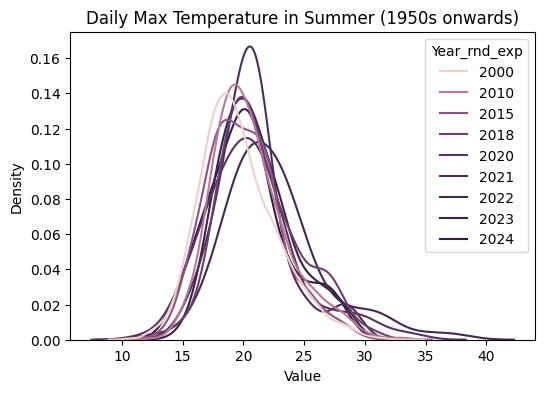

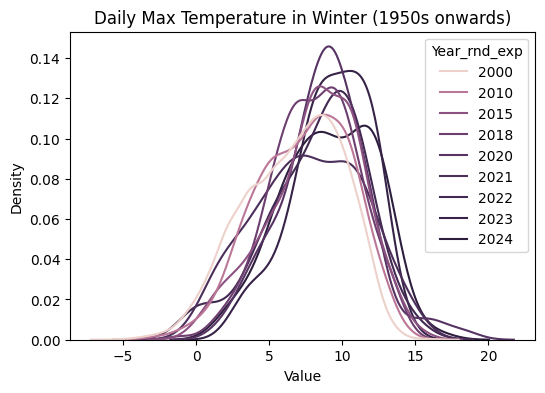

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(
    data=df.filter(pl.col("Year_rnd_exp") < 2025).filter(pl.col("Summer")).to_pandas(),
    x="Value",
    hue="Year_rnd_exp",
    fill=False,
    common_norm=False,
    ax=ax,
)
# ax.set_xlim(20, 40)
ax.set_title("Daily Max Temperature in Summer (1950s onwards)")

fig, ax = plt.subplots(figsize=(6, 4))
sns.kdeplot(
    data=df.filter(pl.col("Year_rnd_exp") < 2025).filter(pl.col("Winter")).to_pandas(),
    x="Value",
    hue="Year_rnd_exp",
    fill=False,
    common_norm=False,
    ax=ax,
)
# ax.set_xlim(20, 30)
ax.set_title("Daily Max Temperature in Winter (1950s onwards)")
fig.show()